In [53]:
import os
import tqdm
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [54]:
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg').eval().cuda()
for param in dinov2.parameters():
    param.requires_grad = False

Using cache found in /home/bea/.cache/torch/hub/facebookresearch_dinov2_main


## Visualize

In [55]:
transform = transforms.Compose([           
    transforms.Resize(520),
    transforms.CenterCrop(518), #should be multiple of model patch_size                 
    transforms.ToTensor(),                    
    transforms.Normalize(mean=0.5, std=0.2)
])
patch_size = dinov2.patch_size # patchsize=14
patch_h  = 520//patch_size
patch_w  = 520//patch_size
feat_dim = 384 # vits14

In [56]:
folder_path = "/datasets/annotation_final_imagenet/static_real/mug/train"
total_features  = []
labels = []
with torch.no_grad():
    for label in tqdm.tqdm(os.listdir(folder_path)):
        for img_path in np.random.choice(os.listdir(os.path.join(folder_path, label)), 24):
            img_path = os.path.join(folder_path, label, img_path)
            img = Image.open(img_path).convert('RGB')
            img_t = transform(img).cuda()

            features_dict = dinov2.forward_features(img_t.unsqueeze(0))
            features = features_dict['x_norm_patchtokens']
            total_features.append(features)
            labels.append(label)

total_features = torch.cat(total_features, dim=0)
labels = np.array(labels)
total_features.shape, labels.shape

100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.40it/s]


(torch.Size([96, 1369, 384]), (96,))

(array([ 1599., 11432., 20305., 20623., 23194., 23176., 17836.,  9550.,
         3488.,   221.]),
 array([0.14229543, 0.22119096, 0.30008649, 0.37898203, 0.45787756,
        0.5367731 , 0.61566863, 0.69456416, 0.7734597 , 0.85235523,
        0.93125077]),
 <BarContainer object of 10 artists>)

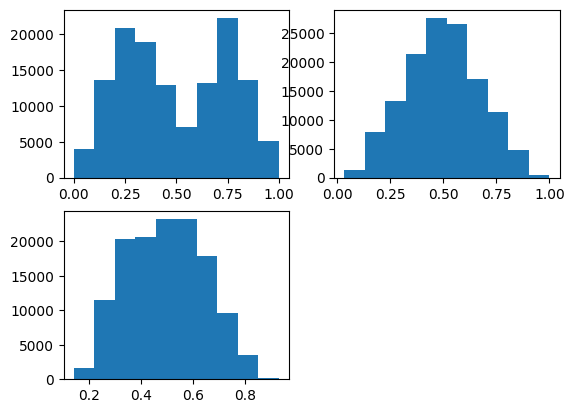

In [57]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(-1, feat_dim).cpu()

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)
pca_features = (pca_features - pca_features[:, 0].min()) / (pca_features[:, 0].max() - pca_features[:, 0].min())
pca_features = np.clip(pca_features, 0, 1)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])

In [64]:
pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())

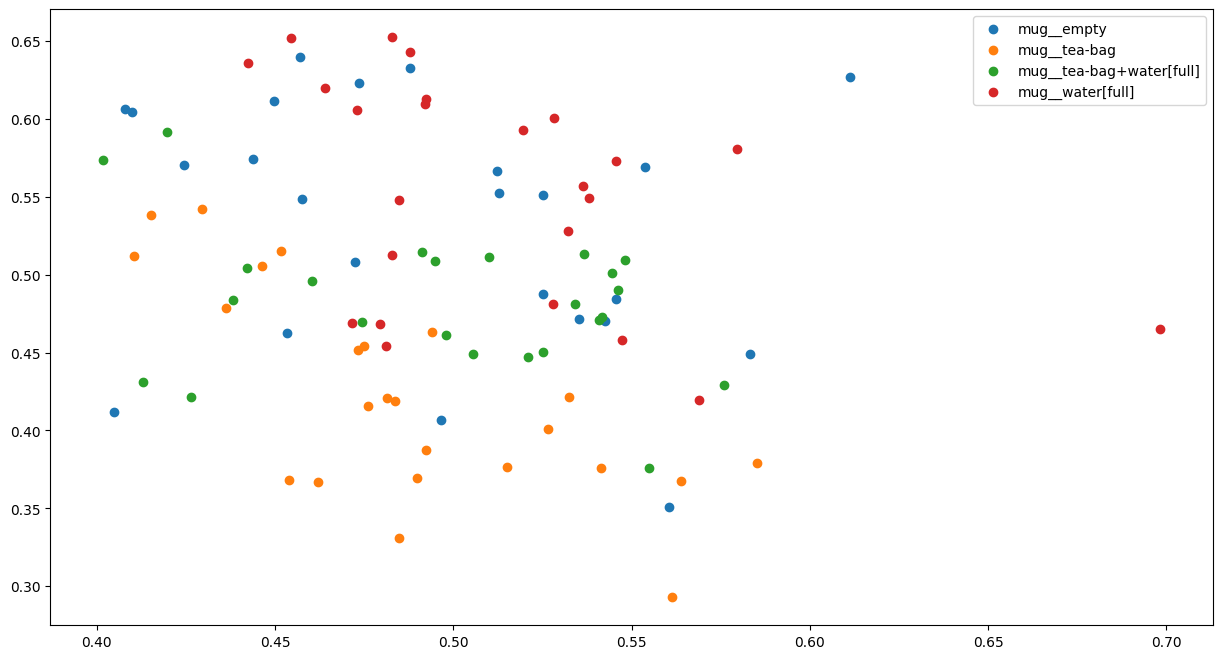

In [72]:
plt.figure(figsize=(15, 8))
for l in np.unique(labels):
    p = pca_features.reshape(-1, patch_h, patch_w, 3).mean(1).mean(1)
    plt.scatter(p[labels==l, 0], p[labels==l, 1], label=l)
plt.legend()

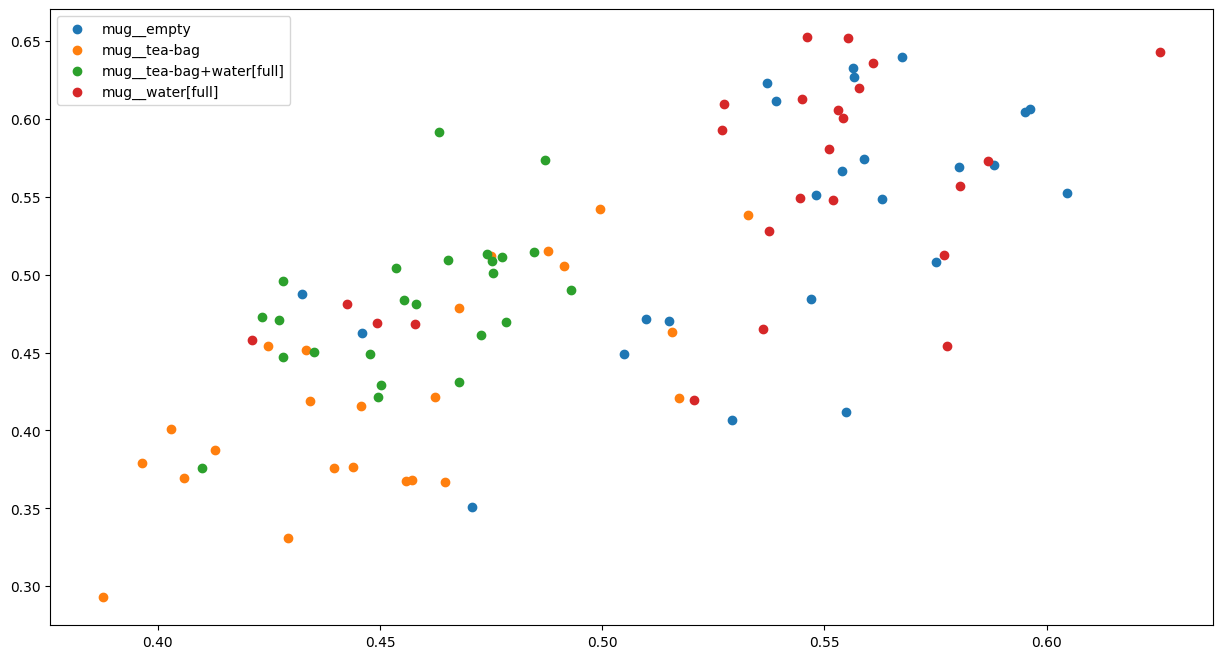

In [71]:
plt.figure(figsize=(15, 8))
for l in np.unique(labels):
    p = pca_features.reshape(-1, patch_h, patch_w, 3).mean(1).mean(1)
    plt.scatter(p[labels==l, 2], p[labels==l, 1], label=l)
plt.legend()

In [ ]:
def plot_features(pca_features, fname):
    cols = 8
    pca_ims = pca_features.reshape(-1, patch_h, patch_w, 3)
    idxs = np.argsort(labels)
    plt.figure(figsize=(32, 4*len(pca_ims)//cols))
    for i in tqdm.tqdm(range(0, len(pca_ims), cols)):
        for j in range(cols):
            if i+j < len(pca_ims):
                plt.subplot(len(pca_ims)//cols+1, cols, i+j+1)
                plt.imshow(pca_ims[idxs[i+j]])
                plt.title(labels[idxs[i+j]])
    plt.tight_layout()
    if fname:
        os.makedirs(os.path.dirname(fname) or '.', exist_ok=True)
        plt.savefig(fname)
        plt.close()

In [43]:
plot_features(pca_features, 'plots/pca.jpg')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 12.17it/s]


In [ ]:
def project_fg(zt, z, thresh, inverse=False):
    # segment/seperate the backgound and foreground using the first component
    bg = zt[:, 0] < 0.35 # from first histogram
    if inverse:
        bg = ~bg
    fg = ~bg
    
    # 2nd PCA for only foreground patches
    pca.fit(total_features[fg]) 
    zt2 = pca.transform(z[fg])
    zt2 = (zt2 - zt2[:, 0].min()) / (zt2[:, 0].max() - zt2[:, 0].min())
    zt2 = np.clip(zt2, 0, 1)
    
    rgb = zt.copy()
    rgb[bg] = 0
    rgb[fg] = zt2
    return rgb

In [ ]:
# # segment/seperate the backgound and foreground using the first component
# pca_features_bg = pca_features[:, 0] < 0.35 # from first histogram
# pca_features_fg = ~pca_features_bg

# # 2nd PCA for only foreground patches
# pca.fit(total_features[pca_features_fg]) 
# pca_features2 = pca.transform(total_features[pca_features_fg])
# pca_features2 = (pca_features2 - pca_features2[:, 0].min()) / (pca_features2[:, 0].max() - pca_features2[:, 0].min())
# pca_features2 = np.clip(pca_features2, 0, 1)

# pca_features_rgb = pca_features.copy()
# # for black background
# pca_features_rgb[pca_features_bg] = 0
# # new scaled foreground features
# pca_features_rgb[pca_features_fg] = pca_features2

pca_features_rgb = project_fg(pca_features, total_features, 0.35)
plot_features(pca_features_rgb, 'plots/pca2.jpg')

## Train

In [42]:
from torch.utils.data import DataLoader, WeightedRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Resize and crop
        transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
        transforms.RandomRotation(10),      # Random rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/datasets/annotation_final_imagenet/static_real/mug'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']}

# Calculate class weights to balance the dataset
class_counts = [image_datasets['train'].targets.count(class_id) for class_id in range(len(image_datasets['train'].classes))]
class_weights = 100.0 / (torch.tensor(class_counts, dtype=torch.float))
class_weights

tensor([0.0300, 0.0261, 0.0939, 0.0482])

In [43]:
class_weights.sum()

tensor(0.1982)

In [44]:
y_true = np.array([y for x,y in image_datasets['train'].samples])
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'], 
        sampler=WeightedRandomSampler(
            np.array(class_weights)[y_true], 
            len(image_datasets['train']), 
            replacement=True),
        # shuffle=True,
        batch_size=16,
        num_workers=4),
    'val': torch.utils.data.DataLoader(
        image_datasets['val'],
        batch_size=16,
        num_workers=4)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
class_names

['mug__empty', 'mug__tea-bag', 'mug__tea-bag+water[full]', 'mug__water[full]']

In [45]:
# next(iter(WeightedRandomSampler(
#             np.array(class_weights)[y_true], 
#             len(image_datasets['train']), 
#             replacement=True)))

In [46]:
# uniq=set()
# for i, (d, yy) in enumerate(dataloaders['train']):
#     for yy in yy.tolist():
#         uniq.add(yy)
#         if len(uniq)>1: 
#             print(i, yy)
#             break

In [47]:
# uniq

In [48]:
class LinearDinoClassifier(nn.Module):
    def __init__(self, dinov2):
        super().__init__()
        self.transformer = dinov2
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, len(class_names))
        )
    
    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        x = F.softmax(x, dim=-1)
        return x

# Create a new classification head using self-attention
class DinoClassifier(nn.Module):
    def __init__(self, model, in_features=feat_dim, num_attention_heads=4, hidden_dim=512):
        super().__init__()
        self.model = model
        self.attention = nn.MultiheadAttention(embed_dim=in_features, num_heads=num_attention_heads)
        self.classifier = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, len(class_names)),
            nn.Softmax(dim=-1),
        )

    def forward(self, x):
        # Apply self-attention
        x = self.model.forward_features(x)['x_norm_patchtokens']
        x, _ = self.attention(x, x, x)
        x = x.mean(dim=1)
        x = self.classifier(x)
        return x

In [49]:
model = DinoClassifier(dinov2).cuda()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [50]:
def eval_plots(X, y, train_dataset, val_dataset):
    classes=np.array(train_dataset.classes)
    val_classes=np.array(val_dataset.classes)
    emission_plot('plots', X, val_classes[y], classes)
    cm_plot('plots', val_classes[y], classes[np.argmax(X, axis=1)], classes)

def emission_plot(plot_dir, X, y, classes, prefix='', show_ypred=False):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20, 16))
    plt.imshow(X.T, cmap='cubehelix', aspect='auto')
    cs = {c: i for i, c in enumerate(classes)}
    classes = list(classes)
    for c in set(y) - set(cs):
        cs[c] = len(cs)
        classes.append(c)
    plt.plot(np.array([cs[yi] for yi in y]), c='r')
    if show_ypred:
        plt.scatter(np.arange(len(X)), np.argmax(X, axis=1), c='white', s=5, alpha=0.2)
    ic = range(len(classes))
    plt.yticks(ic, [classes[i] for i in ic])
    plt.colorbar()
    plt.savefig(f'{plot_dir}/{prefix}emissions.png')
    plt.close()


def cm_plot(plot_dir, y_test, y_pred, classes, prefix=''):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    # classes = np.unique(y_test) if classes is None else classes
    cm = confusion_matrix(y_test, y_pred, labels=classes, normalize='true')*100
    # Plot and save the confusion matrix
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='magma', cbar=False, square=True,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix')
    plt.savefig(f'{plot_dir}/{prefix}confusion_matrix.png')
    plt.close()

In [51]:
from collections import Counter

In [52]:
def train_epoch(epoch):
    running_loss = 0.0
    counter = Counter()
    for i, (inputs, labels) in enumerate(dataloaders["train"]):
        counter.update(labels.tolist())
        # print(inputs.shape)
        # print(labels)
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i and not i % 200:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
            eval_epoch(model, epoch)
            print(counter)

def eval_epoch(model, epoch):
    correct = 0
    total = 0
    result_outputs = []
    result_targets = []
    with torch.no_grad():
        for images, labels in dataloaders["val"]:
            # calculate outputs by running images through the network
            outputs = model(images.to(device))
            result_outputs.append(outputs.detach().cpu().numpy())
            result_targets.append(labels.detach().cpu().numpy())
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.to("cpu") == labels).sum().item()
    X = np.concatenate(result_outputs)
    y = np.concatenate(result_targets)
    classes = dataloaders['train'].dataset.classes
    val_classes = dataloaders['val'].dataset.classes
    emission_plot('plots', X, np.array(val_classes)[y], classes, f'e{epoch}')

    accuracy = correct / total
    print(f'Accuracy of the network on the {len(dataloaders["val"])} batches: {accuracy:.0%}')
    return accuracy, X, y

for epoch in range(12):
    train_epoch(epoch)
eval_epoch(model, epoch)
print('Finished Training')

[1,   201] loss: 4.805
Accuracy of the network on the 33 batches: 19%
Counter({2: 828, 0: 808, 3: 791, 1: 789})
[1,   401] loss: 3.948
Accuracy of the network on the 33 batches: 19%
Counter({2: 1624, 1: 1621, 3: 1602, 0: 1569})
[1,   601] loss: 3.852
Accuracy of the network on the 33 batches: 19%
Counter({2: 2418, 3: 2417, 1: 2404, 0: 2377})
[2,   201] loss: 3.736
Accuracy of the network on the 33 batches: 19%
Counter({2: 824, 1: 813, 0: 798, 3: 781})
[2,   401] loss: 3.681
Accuracy of the network on the 33 batches: 19%
Counter({2: 1651, 3: 1607, 1: 1581, 0: 1577})
[2,   601] loss: 3.662
Accuracy of the network on the 33 batches: 19%
Counter({0: 2421, 2: 2418, 3: 2413, 1: 2364})
[3,   201] loss: 3.635
Accuracy of the network on the 33 batches: 19%
Counter({0: 822, 1: 810, 2: 795, 3: 789})
[3,   401] loss: 3.620
Accuracy of the network on the 33 batches: 19%
Counter({1: 1637, 0: 1613, 2: 1585, 3: 1581})
[3,   601] loss: 3.609
Accuracy of the network on the 33 batches: 19%
Counter({2: 24